In [1]:
import torch

In [2]:
#take random token ids of any words
input_ids = torch.tensor([2, 3, 5, 1])

In [3]:
vocab_size = 6 # total number of words in vocab , above we took 4 out of this 6
output_dim = 3 # vector size of each embedding word

torch.manual_seed(123)

# this creates a lookup values for each token ids in the vocab_size
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

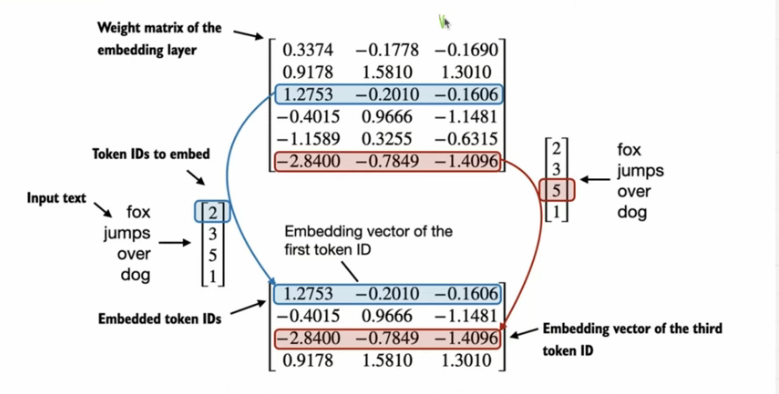

In [4]:
print(embedding_layer)
print(embedding_layer.weight)


Embedding(6, 3)
Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [5]:
# for each word we have a vector ,stored based on id numbers
print(embedding_layer(torch.tensor([1])))

tensor([[0.9178, 1.5810, 1.3010]], grad_fn=<EmbeddingBackward0>)


In [6]:
print(embedding_layer(input_ids)) # here we can give list of tensors of idx

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


We are comparing:
nn.Embedding (used in all LLMs for token embeddings)
nn.Linear (theoretically could do the same with one-hot vectors)

1. Memory efficiency
nn.Linear(vocab_size, embed_dim) requires input as one-hot vectors of size vocab_size.
Example: vocab = 50,000 → one-hot vector = 50,000 floats per token
nn.Embedding(vocab_size, embed_dim) stores only the embedding matrix (vocab_size × embed_dim)
Lookup is O(1) per token, no huge sparse input needed
Conclusion: Embedding is drastically more memory-efficient.

2. Computational efficiency
nn.Linear with one-hot input: output = one_hot @ W
Multiplication with mostly zeros → wasteful
nn.Embedding uses row lookup, no multiply → constant time
Conclusion: Embedding lookup is much faster.

In [7]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        
        #text: book, 
        #tokenizer,
        #Max_length = CONTENT LENGHTH,
        #stride =Stride is how many tokens you move forward when sliding a context window over a long sequence.

        
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length] # if i=1 pick data from 1-4
            target_chunk = token_ids[i + 1: i + max_length + 1] # if i=1 pick data from 2-5
            self.input_ids.append(torch.tensor(input_chunk)) # convert to tensor and append in input
            self.target_ids.append(torch.tensor(target_chunk))# convert to tensor and append in output

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx): 
        # once the input  self.input_ids = [] and self.target_ids = [] TENSORS are ready , 
        #here we provide the index for the row and it fetches that row from these tensors
        return self.input_ids[idx], self.target_ids[idx]

In [13]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    #batch_size = how many samples are processed in parallel in one forward/backward pass.
    #after going through all the batches , model will update the weights
    #here batch=4 ie The model processes 4 independent sequences simultaneously
    #batch_size = 4 → the model does vectorized / parallel math over 4 samples in one forward/backward pass (GPU/CPU will process them together)
    #num_workers = 0 → data loading and preprocessing run serially in the main process. There is no parallelism for preparing batches (reading files, tokenizing, transforms).
    
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [16]:
import importlib
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [17]:
# reading the book
with open(r"Game_of_thrones_books/001ssb.txt",encoding="utf-8") as f:
    raw_text=f.read()

In [25]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)

PyTorch version: 2.9.1+cpu


In [20]:
tokenizer.n_vocab

50257

In [21]:
vocab_size = tokenizer.n_vocab 
output_dim = 128 # vector size of each embedding word

# this creates a lookup values for each token ids in the vocab_size
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [27]:
first_batch[0]

tensor([[   32,  3776,  3226, 20902],
        [  220,   198, 10482,  1881],
        [  286,   317, 10940,   286],
        [ 6663,   290,  3764,   220],
        [  198,  3886,  4502,   371],
        [   13,   371,    13,  5780],
        [  220,   198,  4805, 33462],
        [ 8924,   220,   198,     1]])

In [34]:
#here 8 is the batch of sentence , 4 is number of words , 128 is each word represented in vector
embedding_layer(first_batch[0]).shape

torch.Size([8, 4, 128])

In [39]:
# first row [   32,  3776,  3226, 20902] is converted to this , each scalar is converted to 128
embedding_layer(first_batch[0])[0]

# so we need to add 4 - 128 dim positional encoding 

tensor([[-2.1698e+00,  7.9710e-02,  7.6580e-01,  7.8154e-01,  1.2852e+00,
         -1.0573e-01,  1.8975e-01, -1.0212e+00,  2.2364e-01,  2.4643e-01,
          4.5197e-01,  6.0210e-01,  3.1768e-01,  1.0702e+00,  5.3883e-01,
          1.6078e+00,  1.0366e+00,  1.3973e+00, -2.0226e+00,  4.4800e-01,
          4.1793e-02, -1.0323e+00,  6.9019e-01, -2.3592e-01,  5.1475e-01,
          1.8168e-01, -7.6663e-01,  5.3190e-01, -1.2293e+00,  8.3654e-01,
         -7.7063e-02,  1.4647e+00, -1.9841e-01, -1.2169e+00, -8.2274e-01,
          5.5499e-01, -1.0728e+00,  9.4946e-01, -4.0436e-01, -1.4386e+00,
          8.0011e-01, -1.0057e+00, -1.0507e+00,  1.4119e+00,  9.5878e-01,
          8.3806e-02,  1.7582e+00,  1.0506e+00, -4.7924e-01,  9.3007e-01,
         -1.6161e+00, -8.8078e-01, -3.7551e-02,  1.8027e+00, -7.0978e-01,
         -9.1659e-01,  6.0231e-01,  1.0826e+00,  1.4662e+00, -6.0547e-01,
         -2.6549e-01, -8.1549e-01, -8.0069e-01, -1.7972e+00,  7.1574e-01,
          5.6660e-01,  1.0358e-01,  1.

#in absolute positional encoding , 
we have to create one embedding for the sequence for context length and it can be applied to all the batches 
one 128 vector for pos1
one 128 vector for pos2
one 128 vector for pos3
one 128 vector for pos4

In [42]:
context_length=4
pos_embedding_layer=torch.nn.Embedding(context_length,128)

In [44]:
pos_embeddings = pos_embedding_layer(torch.arange(context_length)) # sequence of 4 postions 0,1,2,3
print(pos_embeddings.shape)

torch.Size([4, 128])


In [45]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [47]:
token_embeddings = embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 128])


In [48]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 128])


In [51]:
pos_embeddings

tensor([[ 4.8669e-01,  7.4781e-01,  3.9202e-01,  2.7097e-01,  3.0251e-01,
         -3.9762e-01, -1.7088e+00, -8.2643e-01,  6.9293e-02,  3.0642e-02,
          1.4895e+00,  1.2360e+00, -7.0863e-01,  3.6277e-02, -2.9295e+00,
         -7.5174e-01,  9.5197e-01,  2.0838e+00,  3.9503e-01, -2.6400e-01,
          5.3985e-01,  2.0280e-01, -7.4045e-01,  2.1422e-01, -5.2239e-01,
         -1.3553e+00,  5.3904e-01, -1.0540e+00,  5.8911e-01,  4.1527e-01,
         -1.2920e+00,  1.0929e+00, -1.2617e+00,  3.5554e-01,  6.7364e-01,
          1.6096e-01,  5.5556e-01,  3.0333e-01, -6.3714e-01,  7.7151e-01,
          1.1835e+00,  1.8955e+00,  6.7943e-01,  1.3070e+00,  1.0198e+00,
          7.8203e-01,  5.3155e-01,  7.4940e-01, -4.7348e-01, -1.0732e+00,
          6.1779e-01,  2.1310e-01, -1.5124e+00, -1.0383e-01,  4.0313e-01,
         -1.6801e-01,  4.4974e-01, -1.2340e+00, -4.8630e-01, -1.0938e+00,
         -1.7600e+00,  3.1073e-01, -5.9668e-01,  2.5542e-01,  3.3633e-01,
         -3.7870e-01, -8.4390e-01,  7.

In [50]:
input_embeddings[0]

tensor([[-1.6831e+00,  8.2752e-01,  1.1578e+00,  1.0525e+00,  1.5877e+00,
         -5.0335e-01, -1.5190e+00, -1.8476e+00,  2.9293e-01,  2.7707e-01,
          1.9415e+00,  1.8381e+00, -3.9095e-01,  1.1065e+00, -2.3907e+00,
          8.5602e-01,  1.9885e+00,  3.4811e+00, -1.6276e+00,  1.8400e-01,
          5.8164e-01, -8.2954e-01, -5.0264e-02, -2.1693e-02, -7.6454e-03,
         -1.1736e+00, -2.2759e-01, -5.2209e-01, -6.4015e-01,  1.2518e+00,
         -1.3691e+00,  2.5576e+00, -1.4601e+00, -8.6131e-01, -1.4910e-01,
          7.1595e-01, -5.1727e-01,  1.2528e+00, -1.0415e+00, -6.6713e-01,
          1.9836e+00,  8.8981e-01, -3.7123e-01,  2.7190e+00,  1.9786e+00,
          8.6584e-01,  2.2898e+00,  1.8000e+00, -9.5272e-01, -1.4313e-01,
         -9.9829e-01, -6.6768e-01, -1.5500e+00,  1.6988e+00, -3.0664e-01,
         -1.0846e+00,  1.0521e+00, -1.5136e-01,  9.7991e-01, -1.6992e+00,
         -2.0254e+00, -5.0476e-01, -1.3974e+00, -1.5418e+00,  1.0521e+00,
          1.8790e-01, -7.4032e-01,  8.

In [52]:
-2.1698e+00+4.8669e-01
#-1.6831e+00,

-1.6831099999999999